In [1]:
import numpy as np
import graspy as gs
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.utils import check_X_y

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed

%matplotlib inline

In [2]:
def discr_stat(
    X, Y, dissimilarity="euclidean", remove_isolates=True, return_rdfs=False
):
    """
    Computes the discriminability statistic.
    Parameters
    ----------
    X : array, shape (n_samples, n_features) or (n_samples, n_samples)
        Input data. If dissimilarity=='precomputed', the input should be the dissimilarity matrix.
    Y : 1d-array, shape (n_samples)
        Input labels.
    dissimilarity : str, {"euclidean" (default), "precomputed"}
        Dissimilarity measure to use:
        - 'euclidean':
            Pairwise Euclidean distances between points in the dataset.
        - 'precomputed':
            Pre-computed dissimilarities.
    remove_isolates : bool, optional, default=True
        Whether to remove data that have single label.
    return_rdfs : bool, optional, default=False
        Whether to return rdf for all data points.
    Returns
    -------
    stat : float
        Discriminability statistic. 
    rdfs : array, shape (n_samples, max{len(id)})
        Rdfs for each sample. Only returned if ``return_rdfs==True``.
    """
    check_X_y(X, Y, accept_sparse=True)

    uniques, counts = np.unique(Y, return_counts=True)
    if (counts != 1).sum() <= 1:
        msg = "You have passed a vector containing only a single unique sample id."
        raise ValueError(msg)
    if remove_isolates:
        idx = np.isin(Y, uniques[counts != 1])
        labels = Y[idx]

        if dissimilarity == "euclidean":
            X = X[idx]
        else:
            X = X[np.ix_(idx, idx)]
    else:
        labels = Y

    if dissimilarity == "euclidean":
        dissimilarities = euclidean_distances(X)
    else:
        dissimilarities = X

    rdfs = _discr_rdf(dissimilarities, labels)
    stat = np.nanmean(rdfs)

    if return_rdfs:
        return stat, rdfs
    else:
        return stat


def _discr_rdf(dissimilarities, labels):
    """
    A function for computing the reliability density function of a dataset.

    Parameters
    ----------
    dissimilarities : array, shape (n_samples, n_features) or (n_samples, n_samples)
        Input data. If dissimilarity=='precomputed', the input should be the 
        dissimilarity matrix.

    labels : 1d-array, shape (n_samples)
        Input labels.

    Returns
    -------
    out : array, shape (n_samples, max{len(id)})
        Rdfs for each sample. Only returned if ``return_rdfs==True``.
    """
    check_X_y(dissimilarities, labels, accept_sparse=True)

    rdfs = []
    for i, label in enumerate(labels):
        di = dissimilarities[i]

        # All other samples except its own label
        idx = labels == label
        Dij = di[~idx]

        # All samples except itself
        idx[i] = False
        Dii = di[idx]

        rdf = [1 - ((Dij < d).sum() + 0.5 * (Dij == d).sum()) / Dij.size for d in Dii]
        rdfs.append(rdf)

    out = np.full((len(rdfs), max(map(len, rdfs))), np.nan)
    for i, rdf in enumerate(rdfs):
        out[i, : len(rdf)] = rdf

    return out

In [3]:
def sample_data(time_steps=10, n_features=100, n_samples=10, minimum=-1, maximum=1, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    out = []
    
    phis = np.random.uniform(minimum, maximum, size=n_samples)
    for phi in phis:
        ar = np.array([1, -phi])
        ma = np.array([1])

        generator = ArmaProcess(ar, ma)
        tmp = generator.generate_sample((time_steps, (n_features * (n_features - 1)) // 2), axis=0)
        tmp /= np.max(np.abs(tmp))

        idx = np.triu_indices(n_features, k=1)

        for t in tmp:
            arr = np.ones((n_features, n_features))
            arr[idx] = t
            arr = gs.utils.symmetrize(arr, 'triu')

            out.append(arr)

    out = np.array(out)
    out = out.reshape(n_samples * time_steps, -1)
    
    # out = euclidean_distances(out)
    
    labels = np.repeat(np.arange(1, n_samples + 1), time_steps)
    
    return out, labels

In [4]:
def compute_disc(minimum=-1, maximum=1):
    X, y = sample_data(minimum=minimum, maximum=maximum)
    
    stat = discr_stat(X, y)
    
    return stat

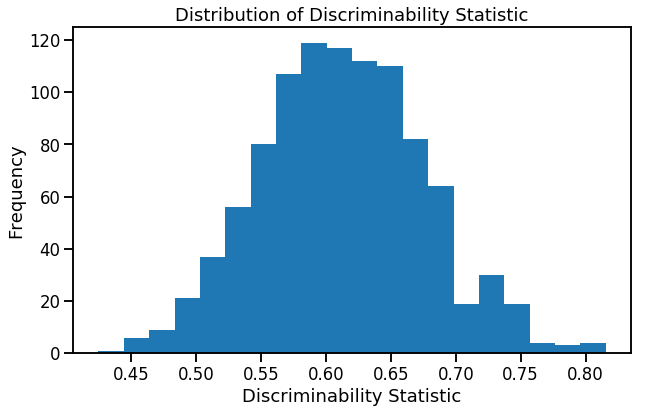

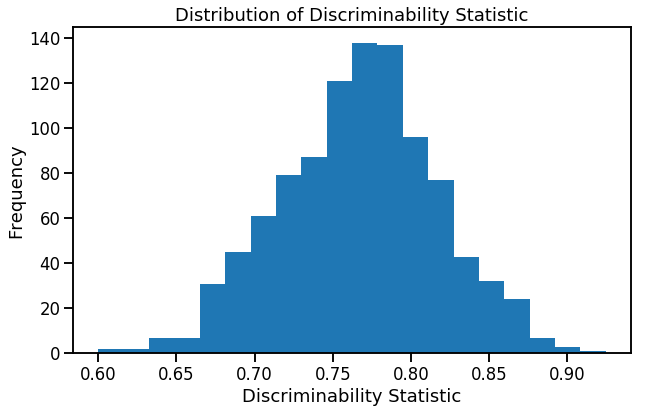

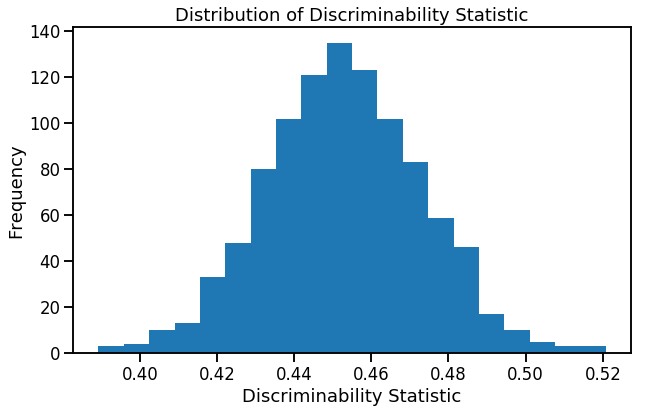

In [5]:
hyperparameters = [(-1, 1), (0, 1), (-1, 0)]

for minimum, maximum in hyperparameters:
    res = Parallel(56, verbose=0)(delayed(compute_disc)(minimum=minimum, maximum=maximum) for _ in range(1000))
    
    with sns.plotting_context('talk'):
        fig, ax = plt.subplots(figsize=(10, 6))

        ax.hist(res, 20)
        ax.set_title("Distribution of Discriminability Statistic")
        ax.set_xlabel("Discriminability Statistic")
        ax.set_ylabel("Frequency")

        fig.savefig(f"discr_dist_min={minimum}_max={maximum}.pdf", dpi=300, bbox_inches='tight')
        fig.savefig(f"discr_dist_min={minimum}_max={maximum}.png", dpi=300, bbox_inches='tight')